In [1]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
import subprocess
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neural_network import MLPClassifier


In [2]:
# lista_de_arquivos = []
# for nome_do_arquivo in os.listdir('imagens/train/T'):
#         # Verifica se é um arquivo (e não um diretório)
#         if os.path.isfile(os.path.join('imagens/train/T', nome_do_arquivo)):
#             lista_de_arquivos.append(nome_do_arquivo)
# lista_de_arquivos.sort()

In [3]:
# indice_inicial = 413
# for i in range(indice_inicial, len(lista_de_arquivos)):
#     nome_atual = f'./imagens/train/T/{lista_de_arquivos[i]}'
#     novo_indice = i + 1
#     nome_novo = f'./imagens/train/T/{novo_indice}.png'
#     os.rename(nome_atual, nome_novo)

In [2]:
label = ["A","B","C","D","E","F","G","I","L","M","N","O","P","Q","R","S","T","U","V","W"]

landmarks = ["WRIST",
    "THUMB_CMC",
    "THUMB_MCP",
    "THUMB_IP",
    "THUMB_TIP",
    "INDEX_FINGER_MCP",
    "INDEX_FINGER_PIP",
    "INDEX_FINGER_DIP",
    "INDEX_FINGER_TIP",
    "MIDDLE_FINGER_MCP",
    "MIDDLE_FINGER_PIP",
    "MIDDLE_FINGER_DIP",
    "MIDDLE_FINGER_TIP",
    "RING_FINGER_MCP",
    "RING_FINGER_PIP",
    "RING_FINGER_DIP",
    "RING_FINGER_TIP",
    "PINKY_MCP",
    "PINKY_PIP",
    "PINKY_DIP",
    "PINKY_TIP"]

In [3]:
# Obtendo o numero de arquivos de imagem de cada letra
num_files = [] # cada elemento da lista é o numero de arquivos de imagem das letras em ordem alfabética
for i,reps in enumerate(label):
    # Caminho do diretório
    directory = f'./imagens/test/{reps}'
    # Executar comando bash para contar o número de arquivos
    count_subprocess_result = subprocess.run(f'find {directory} -type f | wc -l', stdout=subprocess.PIPE, shell=True, text=True)
    output = count_subprocess_result.stdout.strip()
    num_files.append(int(output))

In [11]:
sum(num_files)

10998

In [ ]:
  # Initialize the MediaPipe Hands object
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1718027656.363630   12709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718027656.381010   12710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [6]:
csv_filename = 'test_centro_geometrico.csv'
header = [f'Landmark{i}_{axis}' for i in range(0, 21) for axis in ['x', 'y', 'z']]
header.append('label')


In [7]:
!mkdir imagens_com_problemas_teste

In [10]:
!rm imagens_com_problemas_teste/* # Limpando o diretorio de imagens com problemas
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header) # Inserindo os nomes dos atributos
    for i, reps in enumerate(label): 
        for j in range(1,num_files[i]+1):
            newRow = []
            if(reps == 'F' and j > 300):
                k = j + 100
            else:
                k = j

            caminho = "imagens/test/" + reps + "/" + str(k) + ".png"
            image = cv2.imread(caminho)
            #image_bgr_resized = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)
            # Convert the image to RGB format
            try:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Process the image with MediaPipe Hands
                results = hands.process(image_rgb)
                # Draw hand landmarks on the image
                if results.multi_hand_landmarks:
                    for hand_landmarks in results.multi_hand_world_landmarks:
                        # Print the coordinates of the landmarks
                        for landmark in hand_landmarks.landmark:
                            newRow.append(landmark.x)
                            newRow.append(landmark.y)
                            newRow.append(landmark.z)
                    newRow.append(reps)
                    writer.writerow(newRow)
                else:
                    cv2.imwrite("imagens_com_problemas_teste/imagem" + reps + "00" + str(k) + ".png", image)
            except Exception as e:
                print(caminho)

rm: cannot remove 'imagens_com_problemas_teste/*': No such file or directory


/home/codespace/.python/current/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Landmark coordinates: (0.6523877382278442, 0.9593779444694519, 9.718798992253141e-07)
Landmark coordinates: (0.47858285903930664, 0.9141680598258972, -0.07263526320457458)
Landmark coordinates: (0.34994250535964966, 0.8039156794548035, -0.11959056556224823)
Landmark coordinates: (0.3199617862701416, 0.6761903166770935, -0.16081503033638)
Landmark coordinates: (0.3760685324668884, 0.5885497331619263, -0.19912941753864288)
Landmark coordinates: (0.468181312084198, 0.546904981136322, -0.0673367902636528)
Landmark coordinates: (0.4598695933818817, 0.35412824153900146, -0.12850938737392426)
Landmark coordinates: (0.4678252637386322, 0.2410593181848526, -0.1814889758825302)
Landmark coordinates: (0.48228225111961365, 0.1450943648815155, -0.21945348381996155)
Landmark coordinates: (0.5779491662979126, 0.5234026312828064, -0.07435251027345657)
Landmark coordinates: (0.5760097503662109, 0.309476375579834, -0.1208745539188385)
Landmark coordinates: (0.5829349756240845, 0.17925754189491272, -0.16

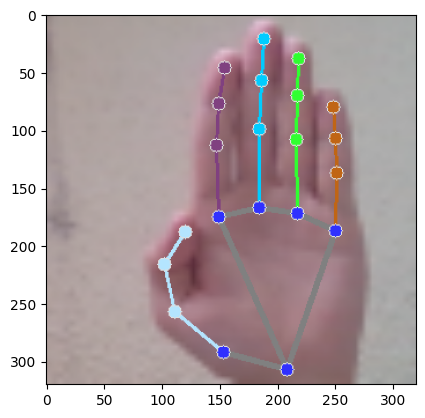

In [8]:
# Draw hand landmarks on the image
if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            image_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        # Print the coordinates of the landmarks
        for landmark in hand_landmarks.landmark:
            print(f"Landmark coordinates: ({landmark.x}, {landmark.y}, {landmark.z})")

# Display the image with hand landmarks
plt.imshow(image_rgb)

<Axes: xlabel='Landmark8_x', ylabel='Landmark8_y'>

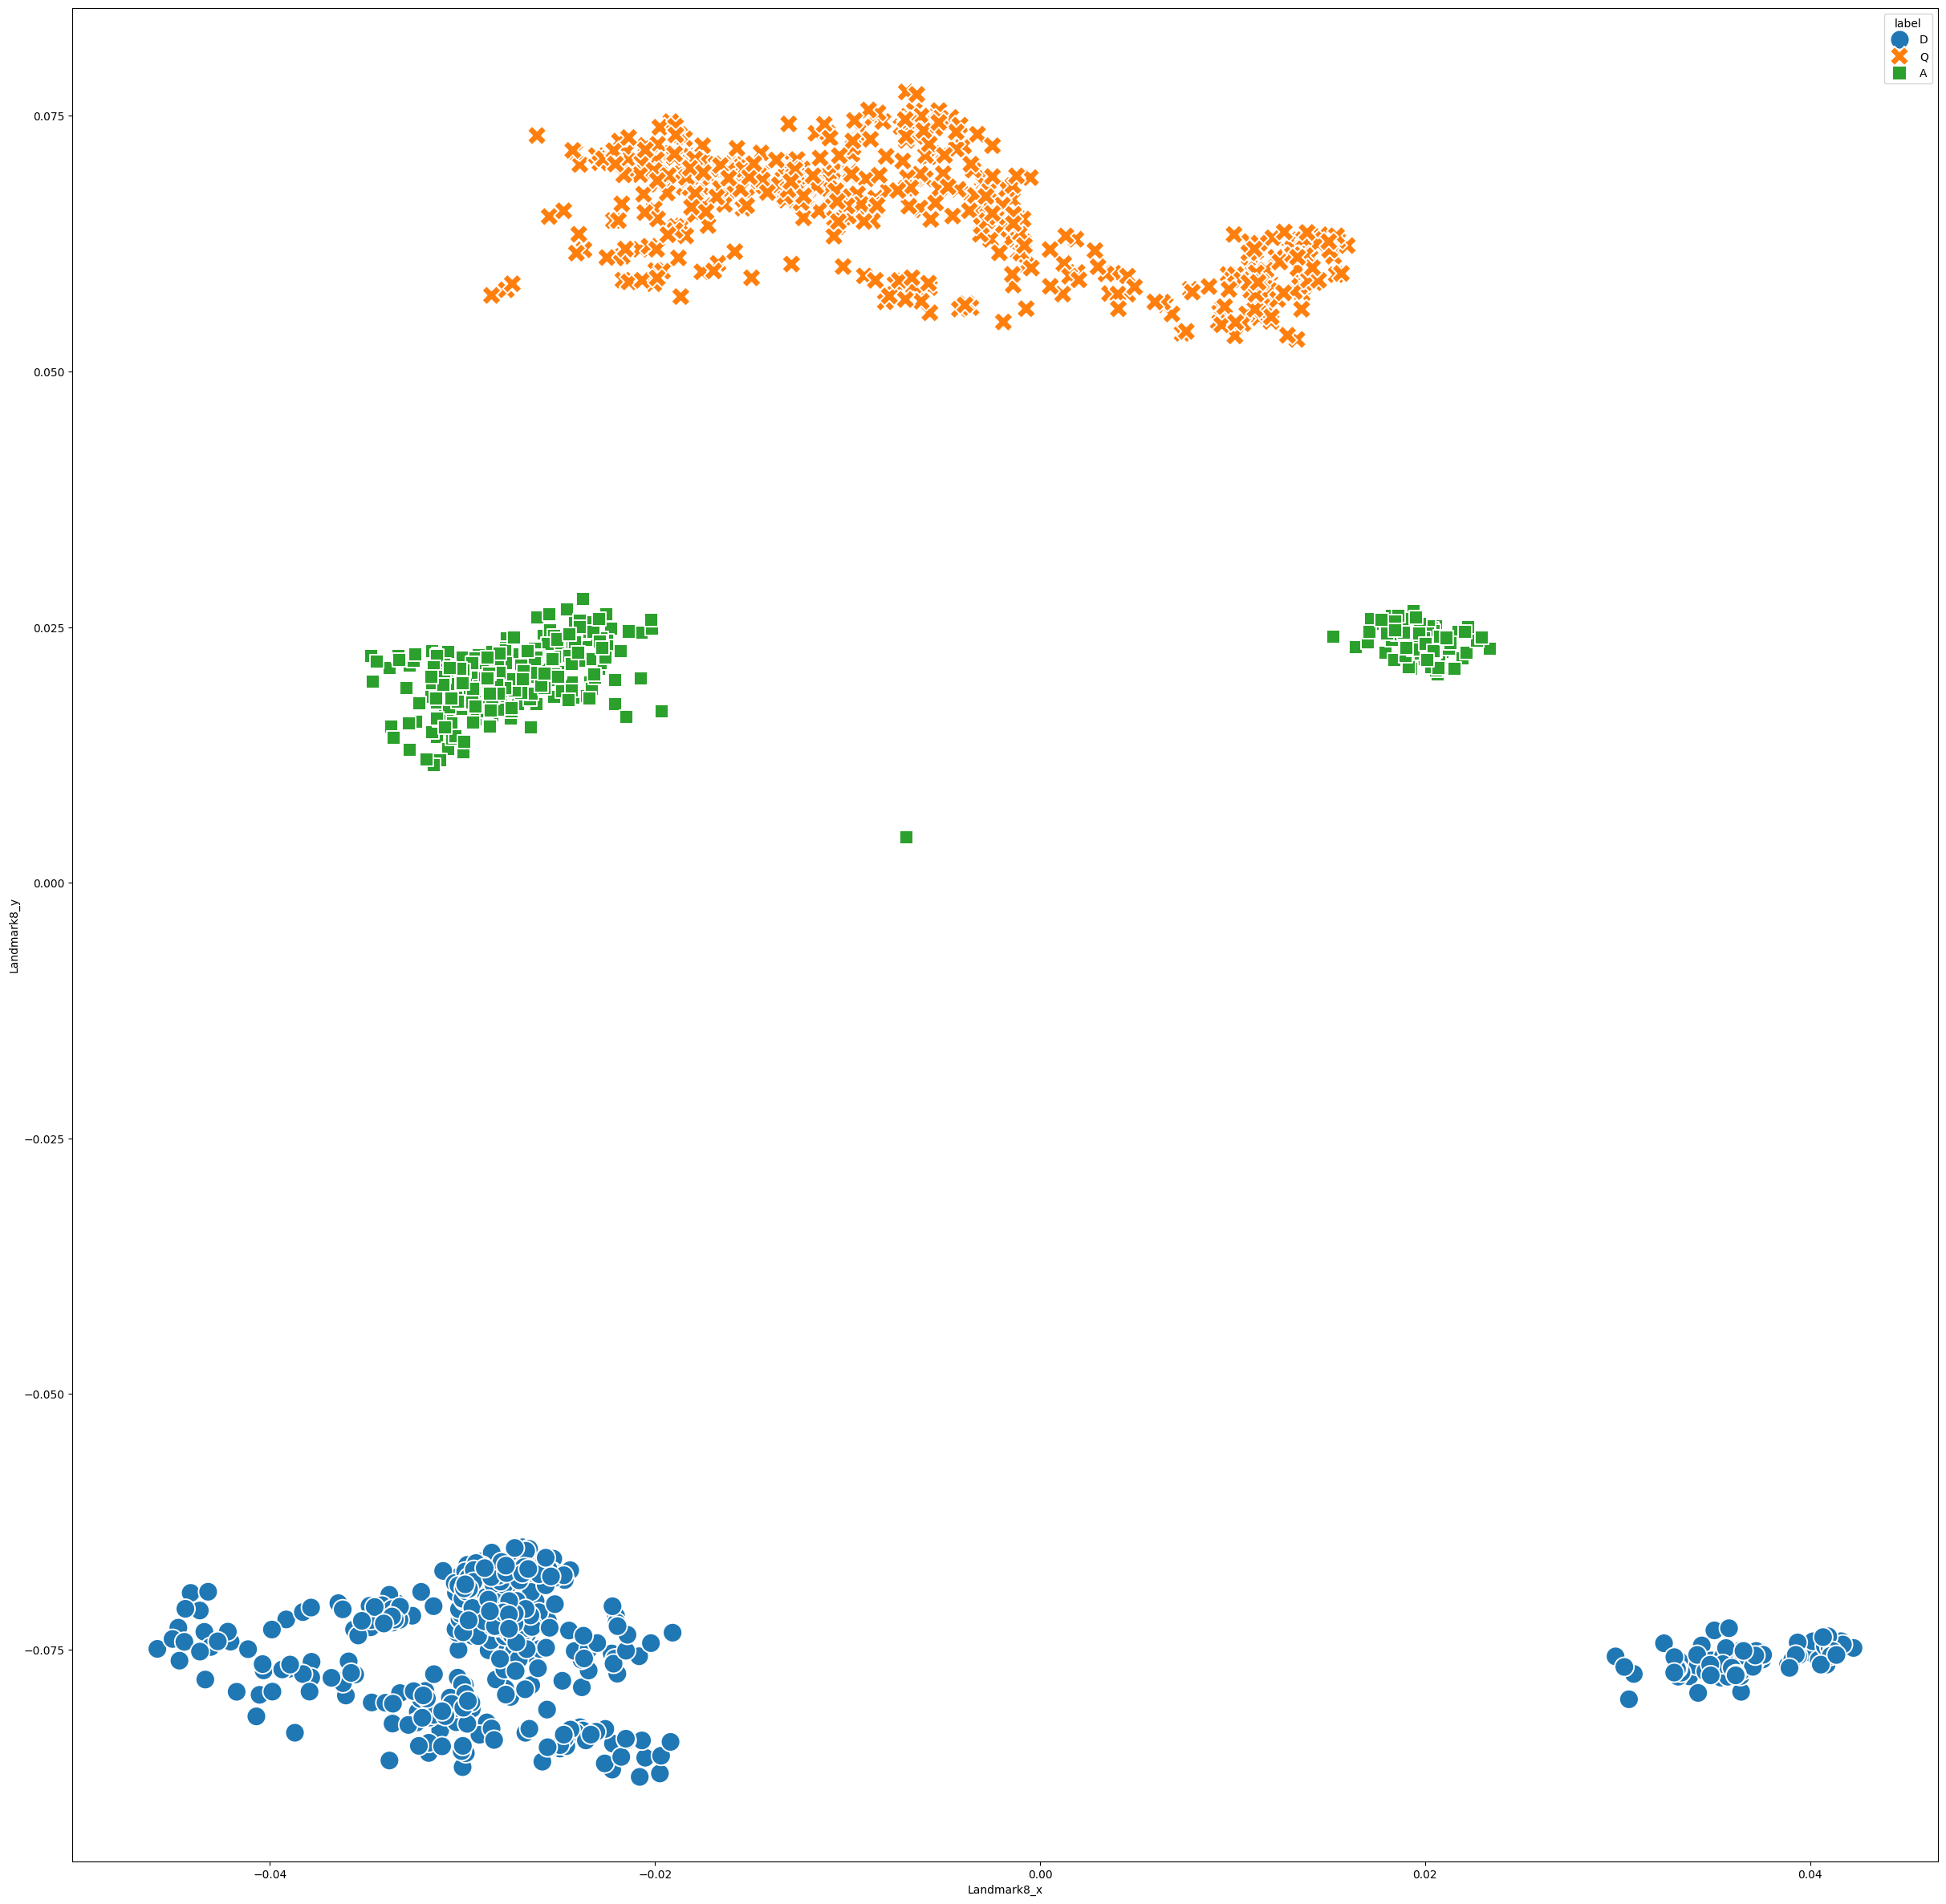

In [30]:
df_train = pd.read_csv('treino_centro_geometrico.csv')
df_train_sample = df_train.sample(n=10000)
plt.figure(figsize=(30, 30))
sns.scatterplot(x='Landmark8_x', y='Landmark8_y', hue='label', style='label', data=df_train_sample[(df_train_sample['label'] == 'D') | (df_train_sample['label'] == 'Q') | (df_train_sample['label'] == 'A') ], s=300)


In [95]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(100, 100), random_state=1, max_iter = 10000)


In [68]:
X_train = df_train.drop(columns=['label'])
y_train = df_train['label']

In [96]:
clf.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(100, 100), max_iter=10000,
              random_state=1, solver='lbfgs')

In [70]:
df_test = pd.read_csv('test_centro_geometrico.csv')

In [81]:
X_test = df_test.drop(columns=['label'])
y_test = df_test['label']

In [97]:
results = clf.predict(X_test)

In [98]:
df_results_compare = pd.DataFrame(results == y_test)
df_results_compare['label'].value_counts()
    

label
True     10852
False       29
Name: count, dtype: int64